# *CurveAnalysis* tutorial 2 : outlier detection

In [1]:
import skfda
from CurveAnalysis_s import fda_feature, outlier_detection
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import BSpline, FDataBasis

C:\Users\berna\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\berna\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\berna\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\berna\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [2]:
skfda.__version__

'0.0'

## Load the weather dataset

We use the same dataset as in the previous tutorial.

In [3]:
weather_dataset = skfda.datasets.fetch_weather()['data']
targets = skfda.datasets.fetch_weather()['target']
target_names = skfda.datasets.fetch_weather()['target_names']

Using TensorFlow backend.


## I. Smoothing

We apply the same methodolody as in the previous tutorial.

**New** : we plot the results depending on the class labels.

In [4]:
curve_analysis = fda_feature.CurveAnalysis(weather_dataset)
history = curve_analysis.smooth_grids()
# scale data before doing analyses
curve_analysis.scale_grids(axis=0, with_std=False)

Default Smoother used
Smoothing data...
Smoothing Done


In [5]:
curve_analysis.

SyntaxError: invalid syntax (<ipython-input-5-0e7735a9d0fe>, line 1)

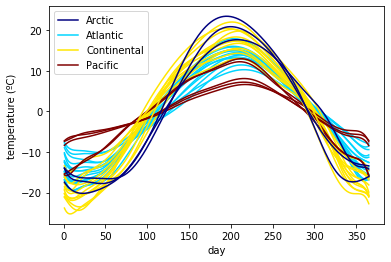

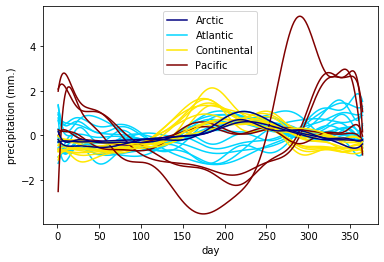

In [6]:
curve_analysis.plot_grids(targets, target_names)

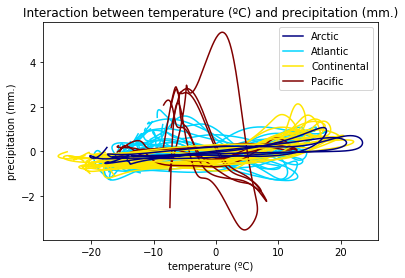

In [7]:
curve_analysis.plot_interaction(targets, target_names)

We store the smoothed grid in a FDataGrid object with the same names as the original one.

In [8]:
fd_smoothed = curve_analysis.coordinates_grids[0].concatenate(
                curve_analysis.coordinates_grids[1], as_coordinates=True)
# keep the same format as the original FDataGrid
fd_smoothed.dataset_label = weather_dataset.dataset_label
fd_smoothed.argument_names = weather_dataset.argument_names
fd_smoothed.coordinate_names = weather_dataset.coordinate_names

## II. Outlier detection
In the library, the algorithms have been adapted to deal with **FDataGrid** objects. The algorithms used are :
- Functional Isolation Forest (univariate and multivariate)
- Isolation Forest
- WDA + K-NN classifier on the projected samples

### II.1. Functional Isolation Forest
The algorithm is the version implemented by Guillaume Staermann, modified to be suitable with *scikit-learn* notations. We have to enter manually the parameters :
- D : Dictionary
- subsample_size : size of the sample to build the tree. It is set by default but here the dataset is too small so we have to choose it manually

In [9]:
params_fif = {'D': 'Brownian_bridge', 
                'subsample_size': 10}
func_ifor = outlier_detection.IForest(functional=True, contamination=0.1, **params_fif)
func_ifor.fit(fd_smoothed)
pred_ifor = func_ifor.predict(fd_smoothed)

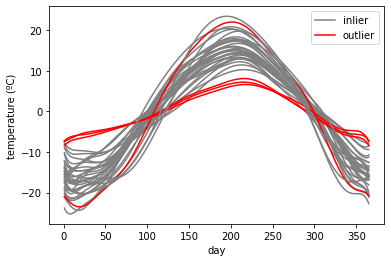

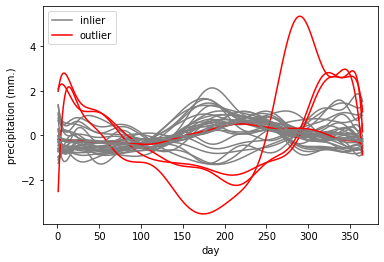

In [10]:
func_ifor.plot_detection(fd_smoothed)

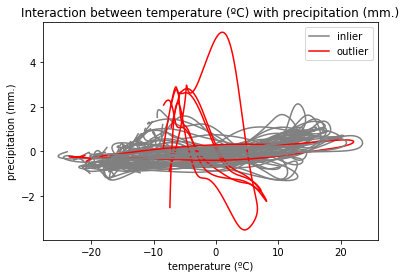

In [11]:
func_ifor.plot_detection(fd_smoothed, plot_interaction=True)

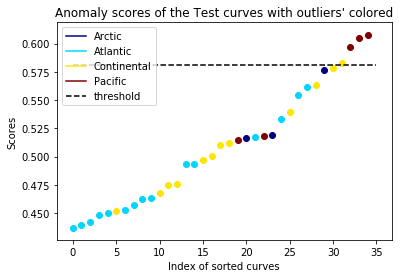

In [12]:
func_ifor.plot_scores(fd_smoothed, targets, target_names)

### II.2. Isolation Forest with curve features

For the example, we compute the different curve features and try two algorithms with these features : non-functional isolation forest and univariate functional isolation forest.

In [13]:
arc_length = curve_analysis.compute_arc_length()
velocity = curve_analysis.compute_velocity()
curvature = curve_analysis.compute_curvature()

for feature in ["arc_length","velocity","curvature"]:
    globals()["%s"%feature].dataset_name = feature
    globals()["%s"%feature].argument_names = ["time"]
    globals()["%s"%feature].coordinate_names = [feature]

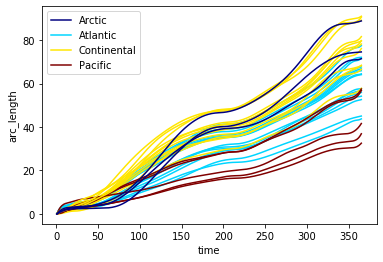

In [14]:
fda_feature.CurveAnalysis(arc_length).plot_grids(targets, target_names)

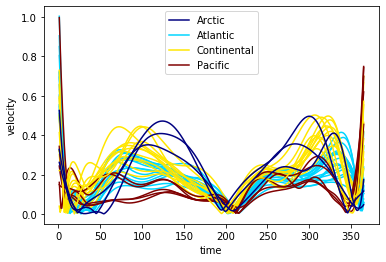

In [15]:
fda_feature.CurveAnalysis(velocity).plot_grids(targets, target_names)

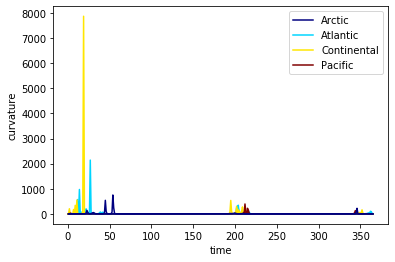

In [16]:
fda_feature.CurveAnalysis(curvature).plot_grids(targets, target_names)

#### Isolation Forest : arc length

In [17]:
ifor = outlier_detection.IForest(functional=False, contamination=0.1)
ifor.fit(arc_length)
pred_if_al = ifor.predict(arc_length)

C:\Users\berna\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\berna\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


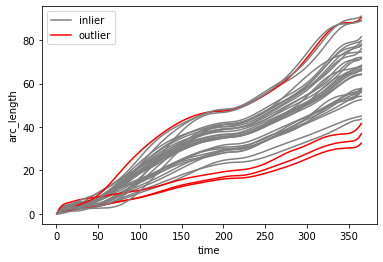

In [18]:
ifor.plot_detection(arc_length)

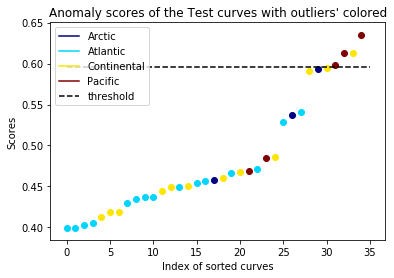

In [19]:
ifor.plot_scores(arc_length, targets, target_names)

#### Univariate functional Isolation Forest : arc length

In [20]:
fifor = outlier_detection.IForest(functional=True, contamination=0.1, **params_fif)
fifor.fit(arc_length)
pred_fif_al = fifor.predict(arc_length)

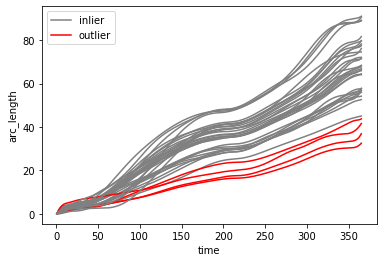

In [21]:
fifor.plot_detection(arc_length)

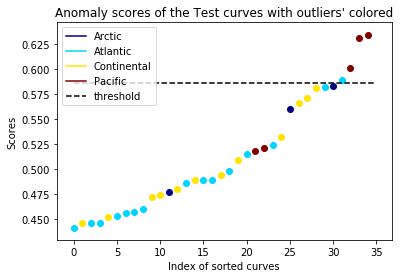

In [22]:
fifor.plot_scores(arc_length, targets, target_names)

### Evaluation

First we have to give labels to our data : suppose that time series corresponding to Pacific Ocean are outliers.

In [23]:
import numpy as np 
labels = targets.copy()
labels[np.where((labels==0) | (labels==1) | (labels == 2))[0]] = 0 # all oceans except pacific are inliers
labels[np.where(labels==3)[0]] = 1 # curves of pacific ocean are outliers
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

In [24]:
scores_fif = func_ifor.score_samples(fd_smoothed)
scores_if_al = ifor.score_samples(arc_length)
scores_fif_al = fifor.score_samples(arc_length)

Let's evaluate the results.

In [25]:
import pandas as pd
results = {}
results["Multivariate Functional Isolation Forest"] = func_ifor.eval_performances(fd_smoothed, labels)
results["Isolation Forest with arc length"] = ifor.eval_performances(arc_length, labels)
results["Functional Isolation Forest with arc length"] = fifor.eval_performances(arc_length, labels)
results = pd.DataFrame(results).transpose().drop(columns=["Accuracy","BA"])
results

,TP,FP,TN,FN,Precision,Recall,f1-score,AUC,AP
Multivariate Functional Isolation Forest,3.0,1.0,29.0,2.0,0.75,0.6,0.666667,0.866667,0.724038
Isolation Forest with arc length,3.0,1.0,29.0,2.0,0.75,0.6,0.666667,0.873333,0.621429
Functional Isolation Forest with arc length,3.0,1.0,29.0,2.0,0.75,0.6,0.666667,0.880000,0.732967


### II.3. WDA + KNN

This classifier is a supervised method. Now we have the labels, we can test it with the data.

In [26]:
from sklearn.neighbors import KNeighborsClassifier
cc = outlier_detection.CustomClassifierWDA(clf=KNeighborsClassifier, 
        projection_size=1, reg=100, contamination=0.1, n_neighbors=4)
cc.fit(fd_smoothed, labels)
pred_cc = cc.predict(fd_smoothed)
scores_cc = cc.score_samples(fd_smoothed)
eval_cc = cc.eval_performances(fd_smoothed, labels)

Compiling cost function...
Computing gradient of cost function...
 iter		   cost val	    grad. norm
    1	+1.3095327783475019e+00	5.18863341e+00
    2	+1.1945122945867887e-04	8.97923867e-03
    3	+1.9294223574740752e-78	1.19858253e-78
Terminated - min grad norm reached after 3 iterations, 0.11 seconds.



ZeroDivisionError: division by zero

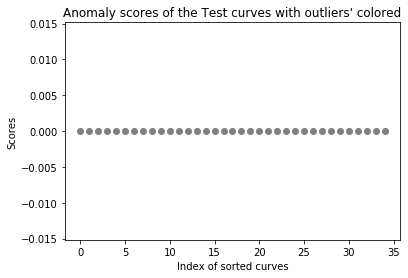

In [27]:
cc.plot_scores(fd_smoothed)

This method is not working correctly for this dataset.